# 1. Introdução

<center> 
<div>
<img src="https://forcaaerea.com.br/wp-content/uploads/2022/04/KC390_JUL2018-1536x1024.jpg" width="600"/>
</div>
(Photo by: Embraer) </center> 

O Registro Aeronáutico Brasileiro (RAB) é uma importante fonte de dados para análises e estudos relacionados à aviação no Brasil. Compreender e extrair informações valiosas desses dados é fundamental para tudo, desde a segurança da aviação até a eficiência operacional da companhia aérea.

Neste trabalho, propomos uma análise abrangente dos dados do Registro Aeronáutico Brasileiro, usando técnicas de análise de dados e aprendizado de máquina. Nosso objetivo é explorar as características dos registros aeronáuticos e aplicar modelos de aprendizado de máquina para identificar tendências, padrões e insights úteis.

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
from category_encoders import TargetEncoder
import optuna
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('aircrafts.csv')

df_old = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23801 entries, 0 to 23800
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   owner                        23787 non-null  object 
 1   owner_id                     22366 non-null  float64
 2   owner_type                   22063 non-null  object 
 3   owner_state                  22744 non-null  object 
 4   num_other_owners             23801 non-null  float64
 5   property_type                23726 non-null  object 
 6   operator                     22880 non-null  object 
 7   operator_id                  21895 non-null  float64
 8   operator_type                21601 non-null  object 
 9   operator_state               22405 non-null  object 
 10  num_other_operators          23801 non-null  float64
 11  use_rights                   7916 non-null   object 
 12  airworthiness                23801 non-null  object 
 13  registration_num

Antes de entrar a dentro da análise dos dados, vamos descrever o que cada campo significa:

**owner:** Dono primário da aeronave. <br>
**owner_id:** Identificador do Dono. <br>
**owner_type:** Dono físico/jurídico (natural/legal) <br>
**owner_state:** Estado do Dono. <br>
**num_other_owners:** Número de outros Donos. <br>
**property_type:** Público/Privado. <br>
**operator:** Operador primário da aeronave. <br>
**operator_id:** Identificador do Operador. <br>
**operator_type:** Operador físico/jurídico (natural/legal) <br>
**operator_state:** Estado do Operador. <br>
**num_other_operators:** Número de outros Operadores. <br>
**use_rights:** Instrumento Legal para o uso da aeronave. <br>
**airworthiness:** Aeronavegabilidade. <br>
**registration_number:** Número de registro. Deve ser exclusivo para cada aeronave. <br>
**certification_type:** Tipo de certificação que o piloto precisa ter para pilotar a aeronave. <br>
**anac_type_classification:** Classificação das características das aeronaves elaborada pela ANAC. <br>
**icao_type_classification:**  Classificação de características de aeronaves criada pela ICAO. <br>
**usage_classification:** Classificação de uso de aeronaves criada pela ANAC. <br>
**annual_inspec_status:** Situação da inspeção anual obrigatória. <br>
**exp_date_annual_inspection:** Data de vencimento da inspeção anual. <br>
**special_inspec_status:** Situação da inspeção especial obrigatória. <br>
**exp_date_special_inspection:** Data de vencimento da inspeção especial. <br>
**model:** Modelo de Avião. <br>
**manufacturer:** Fabricante de avião.  <br>
**serial_number:** Número de série da aeronave. Deve ser exclusivo para cada aeronave produzida em uma linha de produção. <br>
**year_manufacture:** Ano de Fabricação. <br>
**max_weight_takeoff:** Peso máximo de decolagem (MTOW). <br>
**min_number_crew:** Número mínimo de tripulantes. <br>
**max_number_passengers:** Número máixmo de passageiros. <br>
**seats:** Número de assentos. <br>
**landing_type:** Tipo de pouso. <br>
**engine_count:** Número de motores. <br>
**engine_type:** Tipo de motor. <br>

O conjunto de dados pode conter algumas incosistências em razão ao registro e ao próprio processo de limpeza. Uma dessas incosistências é a existência de duplicatas de registro de números de aviação, únicos para cada exemplo, e aviões de peso zero. Vamos removê-los.

In [5]:
df = df.drop_duplicates('registration_number')
df = df.drop(df.loc[df['max_weight_takeoff'] == 0, :].index)

Nossos dados contém um número expressivo de features com dados faltantes. Com uma consulta rápida podemos obter a porcentagem de dados faltantes para cada feature.

In [6]:
for c in df.columns:
    
    per = df.loc[:, c].isnull().sum() / len(df)
    
    print(f'Missing Data in feature {c:27s}: {per * 100:5.2f}%')

Missing Data in feature owner                      :  0.03%
Missing Data in feature owner_id                   :  6.62%
Missing Data in feature owner_type                 :  8.04%
Missing Data in feature owner_state                :  4.86%
Missing Data in feature num_other_owners           :  0.00%
Missing Data in feature property_type              :  0.08%
Missing Data in feature operator                   :  0.02%
Missing Data in feature operator_id                :  2.39%
Missing Data in feature operator_type              :  3.76%
Missing Data in feature operator_state             :  0.04%
Missing Data in feature num_other_operators        :  0.00%
Missing Data in feature use_rights                 : 70.15%
Missing Data in feature airworthiness              :  0.00%
Missing Data in feature registration_number        :  0.00%
Missing Data in feature certification_type         :  5.62%
Missing Data in feature anac_type_classification   :  0.27%
Missing Data in feature icao_type_classi

Baseado no número de dados faltantes e objetivando definir um escopo para a nossa análise de dados, iremos remover algumas features, a fim de focar nas mais importantes.

In [7]:
dropping = ['exp_date_annual_inspection', 'annual_inspec_status',
            'exp_date_special_inspection', 'special_inspec_status',
            'use_rights', 'airworthiness', 'anac_type_classification',
            'icao_type_classification', 'serial_number']

df = df.drop(dropping, axis = 1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21120 entries, 0 to 23800
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   owner                  21113 non-null  object 
 1   owner_id               19722 non-null  float64
 2   owner_type             19423 non-null  object 
 3   owner_state            20094 non-null  object 
 4   num_other_owners       21120 non-null  float64
 5   property_type          21104 non-null  object 
 6   operator               21115 non-null  object 
 7   operator_id            20616 non-null  float64
 8   operator_type          20326 non-null  object 
 9   operator_state         21111 non-null  object 
 10  num_other_operators    21120 non-null  float64
 11  registration_number    21119 non-null  float64
 12  certification_type     19933 non-null  object 
 13  usage_classification   21117 non-null  object 
 14  model                  21101 non-null  object 
 15  ma

# 2. Análise de Dados

## 2.1. Proprietários e operadores

In [9]:
owner_name = len(df.loc[:, 'owner'].unique())
owner_id = len(df.loc[:, 'owner_id'].unique())

print(f'Unique owner names: {owner_name}')
print(f'Unique owner IDs:   {owner_id}')

Unique owner names: 14893
Unique owner IDs:   13123


In [10]:
operator_name = len(df.loc[:, 'operator'].unique())
operator_id = len(df.loc[:, 'operator_id'].unique())

print(f'Unique operator names: {operator_name}')
print(f'Unique operator IDs:   {operator_id}')

Unique operator names: 14868
Unique operator IDs:   13317


O número de donos/operadores supera o número de IDs, isso significa que pode haver donos/operadores com mais de um nome registrado. Isso é importante para consultas a donos/operadores, já que nos informa que não devemos usar os nomes para efetuá-las, e sim suas respectivas IDs.

In [11]:
df['property_type'].value_counts(normalize = True)

Privada    0.979293
Pública    0.020707
Name: property_type, dtype: float64

Há muito pouco exemplos de aeronaves públicas no Brasil.

In [12]:
series = df['owner_id'].value_counts().to_frame().reset_index()
series = series.rename(columns = {'index':'owner_id', 'owner_id': 'num_owned'})
mask = df['owner_id'].isin(series['owner_id'])

df_op = df.loc[mask, ['owner', 'owner_id', 'property_type', 'owner_type']].drop_duplicates('owner_id')

df_op = pd.merge(series, df_op, on = 'owner_id').drop_duplicates('owner_id')

df_op = df_op.drop('owner_id', axis = 1)

#df_op['property_type'] = df_op['property_type'].replace({'Privada': 1, 'Pública': 0})

df_op = df_op[['owner', 'num_owned', 'property_type', 'owner_type']]

df_op.head(20).style.background_gradient(axis=0)

,owner,num_owned,property_type,owner_type
0,BRADESCO LEASING S.A ARREND.MERCANTIL,206,Privada,Legal
1,GOVERNO FEDERAL ANAC,182,Privada,Legal
2,BANCO BRADESCO S.A,104,Privada,Not identified
3,AGENCIA NACIONAL DE AVIACAO CIVIL ANAC,88,Privada,Legal
4,GOVERNO FEDERAL - ANAC,63,Pública,Legal
5,EJ - ESCOLA DE AVIACAO CIVIL LTDA,56,Privada,Legal
6,AIR TRACTOR,50,Privada,Legal
7,SANTANDER LEASING S.A. ARREND.MERCANTIL,46,Privada,Legal
8,HELISUL TAXI AEREO LTDA C240796,43,Privada,Legal
9,AEROCLUBE DE SAO PAULO,42,Privada,Legal


In [13]:
num_nat = df_op[df_op['owner_type'] == 'Natural'].iloc[0, 1]

print(f'Number of highest air fleet owned by a natural owner: {num_nat}')

Number of highest air fleet owned by a natural owner: 13


Observa-se que dentre os vinte donos com as maiores fortas de aviões, A esmagadora maioria é de domínio privado e de pessoas jurídicas. Denota-se que não há uma pessoa física com uma frota aeronáutica superior a 13 aeronaves.

In [14]:
df_ = df.copy()

df = df.loc[:, ['owner_id', 'owner_type', 'owner_state', 'num_other_owners',
           'operator_id', 'operator_type', 'operator_state', 'num_other_operators']].drop_duplicates()

In [15]:
mask1 = (df['owner_type'].isnull())
mask2 = (df['operator_type'].isnull())

df.loc[mask1, 'owner_type'] = 'Not identified'
df.loc[mask2, 'operator_type'] = 'Not identified'

ow_type = df['owner_type'].value_counts(normalize=True) * 100
op_type = df['operator_type'].value_counts(normalize=True) * 100

df_type = pd.concat([ow_type, op_type], axis = 1)
df_type.style.background_gradient(axis=0)

,owner_type,operator_type
Natural,54.940941,52.436584
Legal,35.248177,40.282708
Not identified,9.810882,7.280707


O número de donos físicos supera o número de donos jurídicos, tanto para operadores como para donos. 

In [16]:
# owner state

mask1 = (df['owner_state'].isnull())
mask2 = (df['operator_state'].isnull())

df.loc[mask1, 'owner_state'] = 'Not identified'
df.loc[mask2, 'operator_state'] = 'Not identified'

ow_state = df['owner_state'].value_counts(normalize=True) * 100
op_state = df['operator_state'].value_counts(normalize=True) * 100

df_state = pd.concat([ow_state, op_state], axis = 1)
lst = df_state.index.to_list()
lst.remove('Not identified')
lst.append('Not identified')

df_state = df_state.loc[lst, :]

df_state.style.background_gradient(axis=0)

,owner_state,operator_state
SP,28.316014,26.482928
MG,8.294068,9.036339
PR,7.480798,8.042342
MT,7.003163,8.029433
GO,6.448073,7.054799
RS,5.441167,5.763893
RJ,5.337895,4.363261
PA,4.208352,4.614987
MS,4.053443,4.305170
SC,3.407991,3.614536


Há uma proporção maior de donos e operadores no estad o de São Paulo (SP) e Minas Gerais (MG), sendo ambos os estados mais populosos brasileiros. Entretando, [avaliando a população em outros estados brasileiros](https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o), vê-se que a população nem sempre é um indicativo de proporção de donos e operadores. Mato Grosso (MT) é o 17º estado mais populoso, mas é o 4º com mais donos e operadores.

In [17]:
#df_region

SE = ['SP', 'RJ', 'MG', 'ES'] 
CW = ['MT', 'MS', 'GO', 'DF']
S = ['RS', 'PR', 'SC']
NE = ['MA', 'CE', 'BA', 'PI', 'RN', 'PB', 'PE', 'AL', 'SE']
N = ['AC', 'RO', 'RR', 'AM', 'PA', 'AP', 'TO']

regions = ['SE', 'CW', 'S', 'NE', 'N']

dic_regions = {
    'SE': SE,
    'CW': CW,
    'S': S,
    'NE': NE,
    'N': N
}

df['owner_region'] = 'Not identified'
df['operator_region'] = 'Not identified'

for key, value in dic_regions.items():
    mask1 = df['owner_state'].isin(value)
    mask2 = df['operator_state'].isin(value)
    
    df.loc[mask1, 'owner_region'] = key
    df.loc[mask2, 'operator_region'] = key

ow_region = df['owner_region'].value_counts(normalize=True) * 100
op_region = df['operator_region'].value_counts(normalize=True) * 100

df_region = pd.concat([ow_region, op_region], axis = 1)
df_region.style.background_gradient(axis=0)

,owner_region,operator_region
SE,43.058155,41.012070
CW,20.441490,21.900213
S,16.329955,17.420771
N,9.307429,10.178790
NE,8.474795,9.436520
Not identified,2.388175,0.051636


Olhando-se para a regiões, vê-se que a região Sudeste (SE) concentra a maior parte dos donos e operadores, justificado por ser a região mais populosa. Porém, é seguida pelo Centro Oeste (CW), região com **menor** população. Nordeste (NE), segunda região mais populosa, fica em último lugar em relação a quantidade de donos e operadores. Isso pode ser explicado pela concentração de atividades agropecuárias na região Centro Oeste, que demandam o uso intensivo de aeronaves.

In [18]:
op_num = df['num_other_operators'].value_counts(normalize=True) * 100
ow_num = df['num_other_owners'].value_counts(normalize=True) * 100

df_num = pd.concat([ow_num, op_num], axis = 1)

ind = np.argsort(df_num.index)

df_num = df_num.iloc[ind]

df_num.style.background_gradient(axis=0)

,num_other_owners,num_other_operators
0.000000,94.629833,96.359646
1.000000,3.672626,2.530175
2.000000,1.110179,0.742271
3.000000,0.387272,0.232363
4.000000,0.122636,0.083909
5.000000,0.045182,0.025818
6.000000,nan,0.012909
7.000000,0.019364,0.006455
8.000000,0.012909,nan
13.000000,nan,0.006455



A grande maioria das aeronaves não tem outro operador ou proprietário.

In [19]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_nat = (df.loc[mask1, 'owner_id'] == df.loc[mask1, 'operator_id']).sum() / len(df.loc[mask1]) * 100
self_leg = (df.loc[mask2, 'owner_id'] == df.loc[mask2, 'operator_id']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_id'] != df.loc[mask1, 'operator_id'])
mask4 = (df.loc[mask2, 'owner_id'] != df.loc[mask2, 'operator_id'])

mask5 = (df['operator_type'] == 'Natural')
mask6 = (df['operator_type'] == 'Legal')
mask7 = (df['operator_type'] == 'Not identified')

nat_op_nat = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_nat = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100
nat_op_leg = len(df.loc[(mask3 & mask6)]) / len(df.loc[mask1]) * 100
leg_op_leg = len(df.loc[(mask4 & mask6)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask7)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask7)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_nat, self_leg],
    [nat_op_nat, leg_op_nat],
    [nat_op_leg, leg_op_leg],
    [nat_op_not, leg_op_not],
], index = [
    'operate by owner',
    'operate by natural',
    'operate by legal',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op = df_ow_op.sort_values('natural owner', ascending = False)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
operate by owner,84.515977,68.412379
operate by legal,9.151786,23.585424
operate by natural,5.133929,6.555576
Not identified,1.198308,1.446621


Com base na análise, a maioria das aeronaves são operadas pelos próprios donos, sejam eles físicos ou jurídicos. Vê-se que donos jurídicos operam menos que físicos, e preferem operadores jurídicos quando não são eles que que operam.

In [20]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_state_nat = (df.loc[mask1, 'owner_state'] == df.loc[mask1, 'operator_state']).sum() / len(df.loc[mask1]) * 100
self_state_leg = (df.loc[mask2, 'owner_state'] == df.loc[mask2, 'operator_state']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_state'] != df.loc[mask1, 'operator_state'])
mask4 = (df.loc[mask2, 'owner_state'] != df.loc[mask2, 'operator_state'])

mask7 = (df['operator_state'] == 'Not identified')

nat_op_diff = len(df.loc[(mask3 & ~mask5)]) / len(df.loc[mask1]) * 100
leg_op_diff = len(df.loc[(mask4 & ~mask5)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_state_nat, self_state_leg],
    [nat_op_diff, leg_op_diff],
    [nat_op_not, leg_op_not],
], index = [
    'same state',
    'different state',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op = df_ow_op.sort_values('natural owner', ascending = False)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
same state,93.573778,81.541842
different state,3.277726,14.484527
Not identified,3.148496,3.973631


Os operadores geralmente são do mesmo estado que os donos, havendo mais operadores do mesmo estado quando os donos são físicos.

In [21]:
mask1 = (df['owner_type'] == 'Natural')
mask2 = (df['owner_type'] == 'Legal')

self_region_nat = (df.loc[mask1, 'owner_region'] == df.loc[mask1, 'operator_region']).sum() / len(df.loc[mask1]) * 100
self_region_leg = (df.loc[mask2, 'owner_region'] == df.loc[mask2, 'operator_region']).sum() / len(df.loc[mask2]) * 100

mask3 = (df.loc[mask1, 'owner_region'] != df.loc[mask1, 'operator_region'])
mask4 = (df.loc[mask2, 'owner_region'] != df.loc[mask2, 'operator_region'])

mask7 = (df['operator_state'] == 'Not identified')

nat_op_diff = len(df.loc[(mask3 & ~mask5)]) / len(df.loc[mask1]) * 100
leg_op_diff = len(df.loc[(mask4 & ~mask5)]) / len(df.loc[mask2]) * 100
nat_op_not = len(df.loc[(mask3 & mask5)]) / len(df.loc[mask1]) * 100
leg_op_not = len(df.loc[(mask4 & mask5)]) / len(df.loc[mask2]) * 100

df_ow_op = pd.DataFrame(data = [
    [self_region_nat, self_region_leg],
    [nat_op_diff, leg_op_diff],
    [nat_op_not, leg_op_not],
], index = [
    'same region',
    'different region',
    'Not identified'
], columns = [
    'natural owner',
    'legal owner'
]

)

df_ow_op.style.background_gradient(axis=0)

,natural owner,legal owner
same region,95.030545,86.705732
different region,2.384868,10.199597
Not identified,2.584586,3.094671


Observa-se o mesmo padrão para regiões que vimos em estados.

In [22]:
mask = (df['owner_state'] == df['operator_state'])
mask_not = (df['operator_state'] == 'Not identified') | (df['owner_state'] == 'Not identified')


df['same_state'] = 0

df.loc[mask, 'same_state']  = 1

df_same_state = df.loc[~mask_not, ['owner_state', 'same_state']].groupby('owner_state').sum()['same_state']

df_same_state = df_same_state / df.loc[~mask_not, 'owner_state'].value_counts() * 100 

df_same_state = df_same_state.sort_values(ascending=False)

df_same_state.to_frame(name = 'owner_same_state').style.background_gradient(axis=0)

,owner_same_state
AL,100.000000
PE,98.360656
RN,95.312500
MG,94.310210
MA,93.953488
GO,93.793794
CE,93.750000
MT,93.640553
PB,93.421053
RS,93.238434


Rio de Janeiro (RJ) e Distrito Federal (DF) são os estados com menor número de proprietários com operadoras no mesmo estado.

In [23]:
mask = (df['owner_region'] == df['operator_region'])
mask_not = (df['operator_region'] == 'Not identified') | (df['owner_region'] == 'Not identified')

df['same_region'] = 0

df.loc[mask, 'same_region']  = 1

df_same_state = df.loc[~mask_not, ['owner_region', 'same_region']].groupby('owner_region').sum()['same_region']

df_same_state = df_same_state / df.loc[~mask_not, 'owner_region'].value_counts() * 100 

df_same_state = df_same_state.sort_values(ascending=False)

df_same_state.to_frame(name = 'owner_same_region').style.background_gradient(axis=0)

,owner_same_region
S,94.071146
N,93.962526
NE,93.830922
CW,93.274392
SE,89.857464


In [24]:
big_op  = df.groupby('operator_id').count()['owner_id'].sort_values(ascending = False).head(20)


In [25]:
series = df_.loc[:, ['operator_id', 'operator', 'operator_state']].drop_duplicates()

df_op = pd.merge(series, big_op, on = 'operator_id').drop_duplicates('operator_id')

df_op = df_op.drop('operator_id', axis = 1)

df_op = df_op.rename(columns = {
    'owner_id': 'num_owners'
}).sort_values('num_owners', ascending = False)

df_op.style.background_gradient(axis=0)

,operator,operator_state,num_owners
9,LIDER TAXI AEREO S.A - AIR BRASIL,MG,17
18,AEROCLUBE DE JUIZ DE FORA,MG,14
42,AEROCLUBE DO ESTADO DE MINAS GERAIS,MG,13
16,AEROCLUBE DE GOIAS,GO,12
22,ICON TAXI AEREO LTDA,SP,12
24,PIQUIATUBA TAXI AEREO LTDA,PA,11
33,COMBATE AVIAÇÃO AGRICOLA LTDA ¿ ME,GO,11
60,JOAO VIVIANI,SP,10
19,HELISUL TAXI AEREO LTDA,PR,10
39,TACA TAXI AEREO CANDIDO LTDA,PA,10


Os operadores com maior número de aeronaves pilotadas são aeroclubes ou táxis aéreos, com concentração no estado de Minas Gerais (MG).

In [26]:
df = df_.copy()

In [27]:
SE = ['SP', 'RJ', 'MG', 'ES'] 
CW = ['MT', 'MS', 'GO', 'DF']
S = ['RS', 'PR', 'SC']
NE = ['MA', 'CE', 'BA', 'PI', 'RN', 'PB', 'PE', 'AL', 'SE']
N = ['AC', 'RO', 'RR', 'AM', 'PA', 'AP', 'TO']

regions = ['SE', 'CW', 'S', 'NE', 'N']

dic_regions = {
    'SE': SE,
    'CW': CW,
    'S': S,
    'NE': NE,
    'N': N
}

df['owner_region'] = 'Not identified'
df['operator_region'] = 'Not identified'

for key, value in dic_regions.items():
    mask1 = df['owner_state'].isin(value)
    mask2 = df['operator_state'].isin(value)
    
    df.loc[mask1, 'owner_region'] = key
    df.loc[mask2, 'operator_region'] = key

## 2.2. Classificação de Uso

In [28]:
series = df['usage_classification'].value_counts(normalize=True).to_frame() * 100

series.style.background_gradient(axis=0)

,usage_classification
TPP,49.145238
PET,22.621585
PRI,7.856230
SAE,7.785197
TPX,6.160913
TPR,3.025998
ADE,1.510631
TPX/SAE,0.752948
ADF,0.298338
TPN,0.203627


Para entender a classificação para uso, segue uma lista de significado das siglas de cada uma das aeronaves. <br>

ADF: Pública Administração Direta Federal. <br>
ADE: Pública Administração Direta Estadual. <br>
ADM: Pública Administração Direta Municipal. <br>
ADD: Pública Administração Direta Distrito Federal. <br>
PIN: Pública Instrução. <br>
PEX: Pública Experimental. <br>
AIF: Pública Administração Indireta Federal. <br>
AIE: Pública Administração Indireta Estadual. <br>
AIM: Pública Administração Indireta Municipal. <br>
AID: Pública Administração Indireta Distrito Federal. <br>
SAE: Privada Serv. Aéreo Especializado Púb. <br>
TPR: Privada Serv. Transp. Aéreo Púb. Regular.  <br>
TPN: Privada Serv. Transp. Aéreo Púb. Não Regular. <br>
TPX: Privada Serv. Transp. Aéreo Púb. Não Regular Taxi Aéreo. <br>
TPP: Privada Serv. Aéreos Privados  <br>
PRI: Privada Instrução <br>
PET: Privada Experimental <br>
PRH: Privada Histórica <br>

Conforme esperado, a vasta maioria das aplicações são para uso privado, tendo como categorias majoritárias a TPP e a PET. Aeronaves experimentais não necessitam cumprir certas regulamentações, embora necessite sim de avaliações feitas pela ANAC para que o projeto seja seguro. Vale ressaltar que tais aeronaves não podem ser utilizadas para transporte de pessoas e objetos para fins lucrativos.

## 2.3. Modelo e Fabricante

In [29]:
series = df['model'].value_counts().to_frame().head(20)

SS = {}

for s in series.index:
    m = df.loc[df['model'] == s, 'manufacturer']
    n = m.unique()
    if len(n) < 2:
        ss = ' '.join([s, f'({n[0]})'])

    elif len(n) < 4:
        n = '/'.join(n)
        ss = ' '.join([s, f'({n})'])

    else:
        ss = ' '.join([s, '(MULTIPLE)'])
    
    ss = ss.replace(' AIRCRAFT', '')
    ss = ss.replace(' FRANCE', '')
    
    SS[s] = ss
    
series = series.rename(index=SS)
series = series.rename(columns = {'model': 'Quantity'})
series.style.background_gradient(axis=0)

,Quantity
182P (CESSNA),452
RV-10 (MULTIPLE),409
EMB-810D (NEIVA/EMBRAER),405
EMB-810C (EMBRAER/NEIVA),385
EMB-202 (EMBRAER/NEIVA),382
EMB-201A (NEIVA),358
R44 II (ROBINSON HELICOPTER),326
SR22 (CIRRUS DESIGN),319
58 (BEECH/RAYTHEON),274
EMB-202A (EMBRAER/NEIVA),270


A aeronave Cessna 182P é a aeronave mais popular no Brasil, seguida pela RV-10, o qual é um kit aeronáutico que pode ser montado por diferentes fabricantes. Os próximos exemplos são aeronaves da Neiva ou Embraer. Neiva se trata de uma empresa adquirida pela Embraer na década de 80 e integrada a empresa em 2006, tendo como foco a fabricação de aviões agrícolas.

In [30]:
series = df.loc[:, ['model', 'manufacturer']].drop_duplicates(
).groupby('model'
).count(
).sort_values('manufacturer', 
              ascending = False
).head(20)

series.style.background_gradient(axis=0)

,manufacturer
model,
RV-10,267
RV-9A,105
RV-7A,51
ADVENTURE,49
CONQUEST 180,47
BRAVO 700,40
SUPER PETREL LS,37
RV-7,30
PARADISE I,29


Conforme dito anteriormente, RV-10 é um kit aeronáutico e pode ter múltiplos fabricantes, assim como outros kits aeronáuticos apresentados acima.

In [31]:
series = df['manufacturer'].value_counts().to_frame().head(20)

series.style.background_gradient(axis=0)

,manufacturer
CESSNA AIRCRAFT,3853
NEIVA,2441
PIPER AIRCRAFT,1612
EMBRAER,1453
BEECH AIRCRAFT,1241
ROBINSON HELICOPTER,764
AIR TRACTOR,415
CIRRUS DESIGN,379
BELL HELICOPTER,314
HELIBRAS,307


A Cessna é a fabricante mais popular, seguida pela Neiva, Piper e Embraer.

## 2.4. Tipo de aterrisagem

In [32]:
series = df['landing_type'].value_counts(normalize = True).to_frame() * 100 #.head(20)

series.style.background_gradient(axis=0)

,landing_type
Conventional Landing,88.974359
Helicopter,9.966762
Amphibian,1.049383
Water Landing,0.009497


O tipo de aterrisagem mais comum é o convencional. Em outras palavras, o avião tradicional que necessita de certa pista para pousar. O segundo é helicóptero, necessitando de um ponto adequado para pouso. Os outros dois menos frequentes são anfibios, que podem pousar tanto na terra quanto na água, e pousagem exclusiva na água.  

In [33]:
series = df['engine_type'].value_counts(normalize = True).to_frame() * 100 #.head(20)

series.style.background_gradient(axis=0)

,engine_type
Piston,77.497626
Turboprop/Turboshaft,14.064577
Jet,6.239316
No Engine,2.179487
Electric,0.018993


Os motores a pistão são mais prevalentes no cenário da aviação no Brasil, o que é uma tendência esperada. A maioria das aeronaves no país possui capacidade para poucos tripulantes e são operadas pelos próprios proprietários. Essa preferência pelos motores a pistão se dá devido a algumas vantagens, como menor custo de aquisição, manutenção simplificada e familiaridade por parte dos operadores. Aviões sem motores se tratam de planadores, que necessitam de uma tração inicial para alçar voo.

## 2.4. Features Numéricas

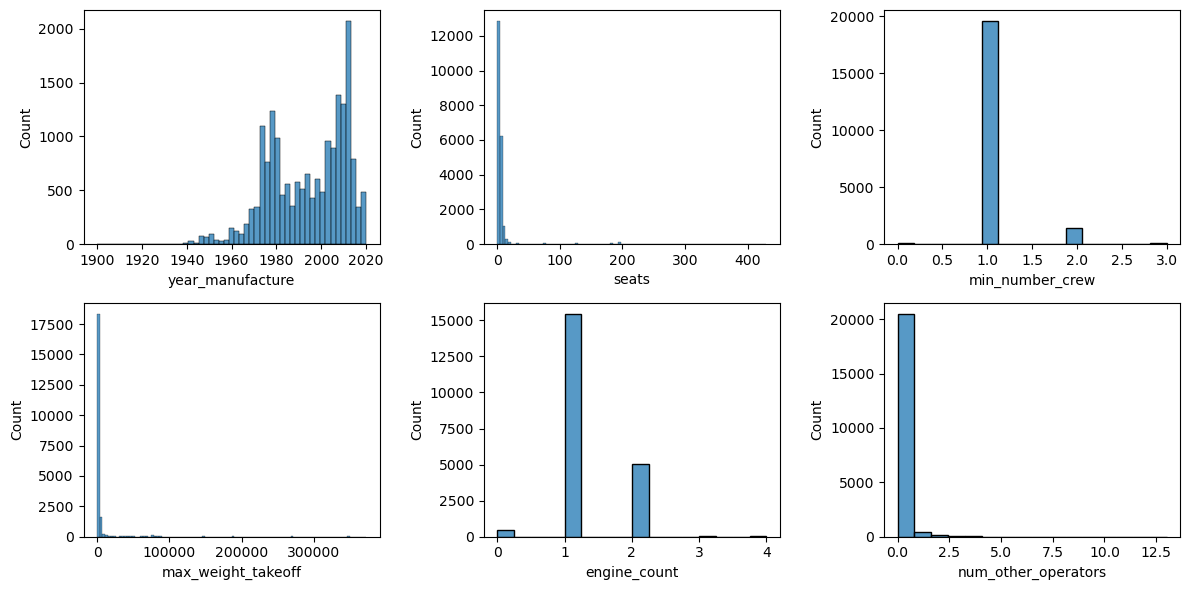

In [34]:
df_num = df.loc[:, ['year_manufacture', 'seats', 'min_number_crew',
                     'max_weight_takeoff', 'engine_count', 'num_other_operators']]

fig,ax = plt.subplots(2, 3, figsize = (12, 6))

for i, c in enumerate(df_num.columns):
    
    if c == 'max_weight_takeoff' or c == 'seats':
        
        sns.histplot(data = df, x = c, bins = 100, ax = ax[i//3, i%3])
        
    else:
        sns.histplot(data = df, x = c, ax = ax[i//3, i%3])

fig.tight_layout()

Podemos ter os seguintes insights com base nos histogramas confeccionados.

* Houveram dois momentos de grande manufatura de aeronaves: Final da década de 60 e ínício da década de 2010.
* Assentos e MTOW possuem uma distribuição distorcida à direita. 
* A vasta maioria de aviões necessitam de apenas um tripulante.
* A maioria dos aviões possuem um motor, seguido por aviões que possuem dois. Aviões com mais de dois são muito raros, assim como planadores.
* Como visto anteriormente, é raro aviões terem mais de um operador.

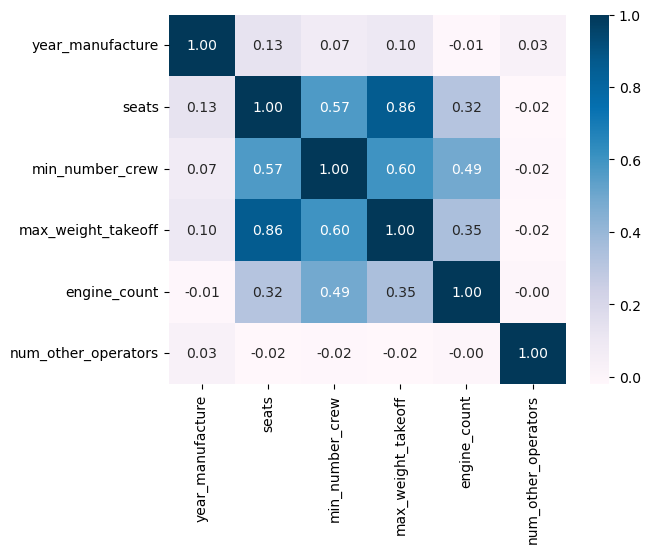

In [36]:
sns.heatmap(df_num.corr(), annot = True, fmt = '.2f', cmap = 'PuBu');

* Assentos tem uma forte correlação linear com MTOW, o que é esperado. Apenas aviões maiores e consequentemente mais pesados podem carregar mais passageiros.
* Número Mínimo de Tripulantes e Número de Motores estão moderadamente correlacionados com MTOW e Assentos. Aviões maiores podem necessitar de mais tripulantes e motores.

## 2.5. Análise de Distribuição

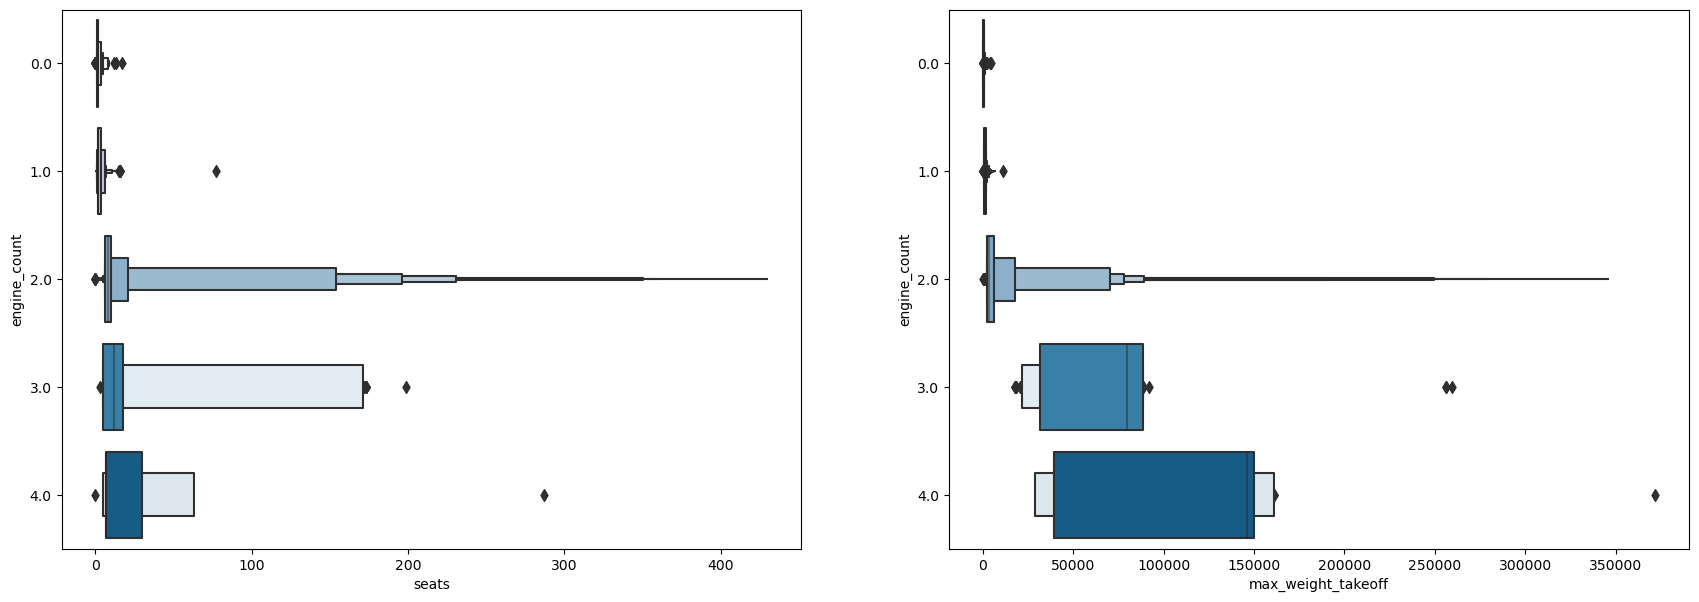

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'engine_count', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'engine_count', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);

Aviões com dois motores tem uma maior variedade de MTOW e assentos, apesar de não ser o tipo de avião mais comum. A medida que se acresce mais motores, o avião tem tendência a aumentar seu MTOW, conforme observado.


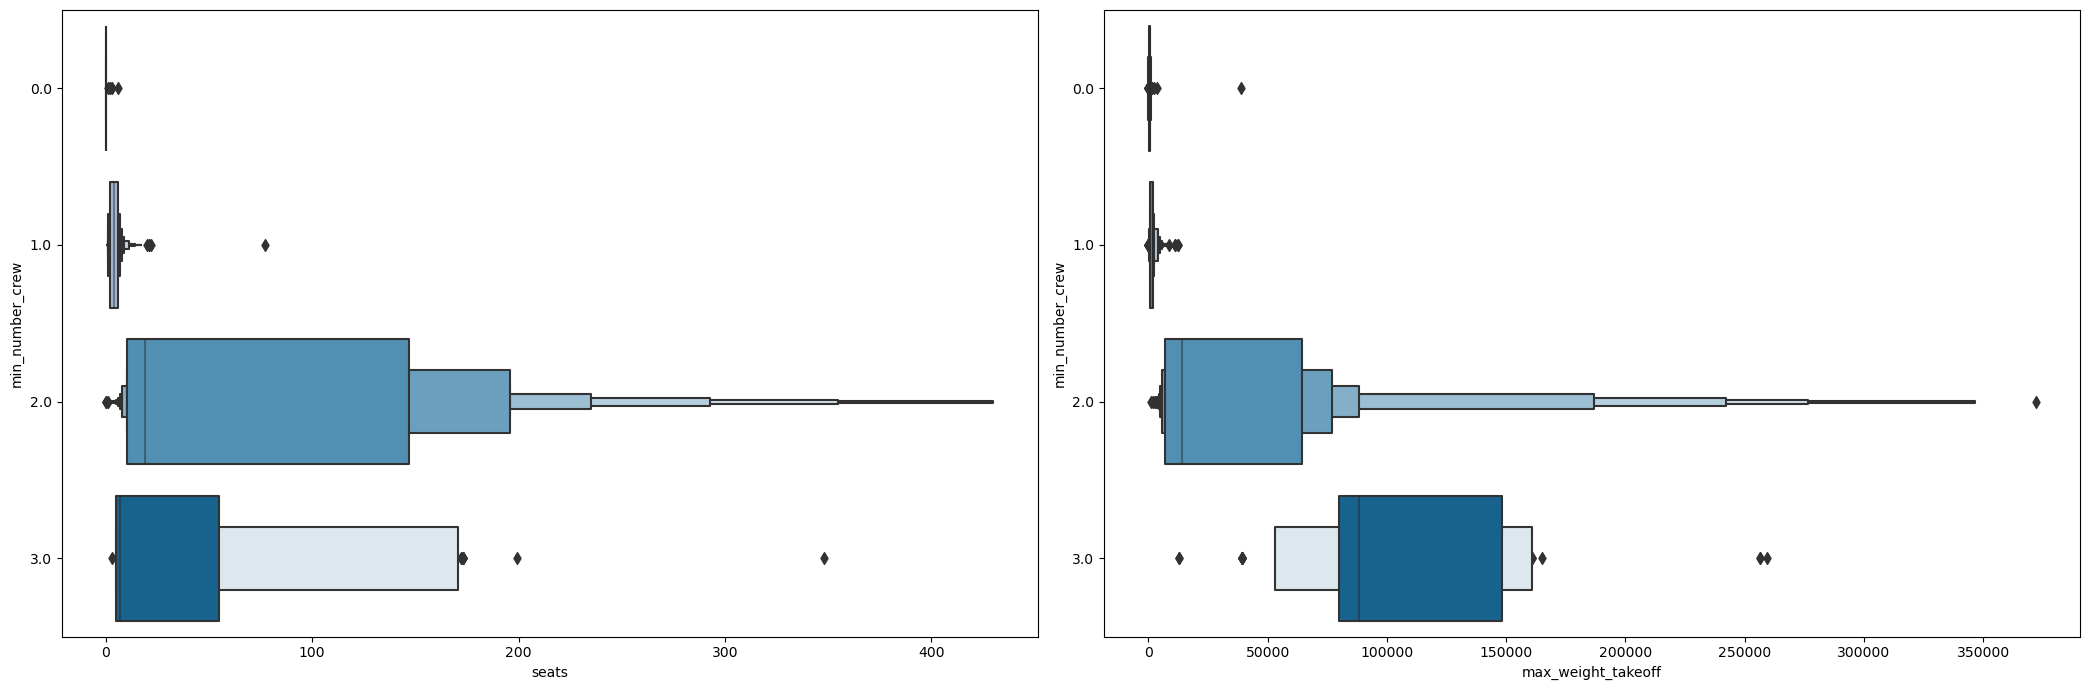

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'min_number_crew', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'min_number_crew', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

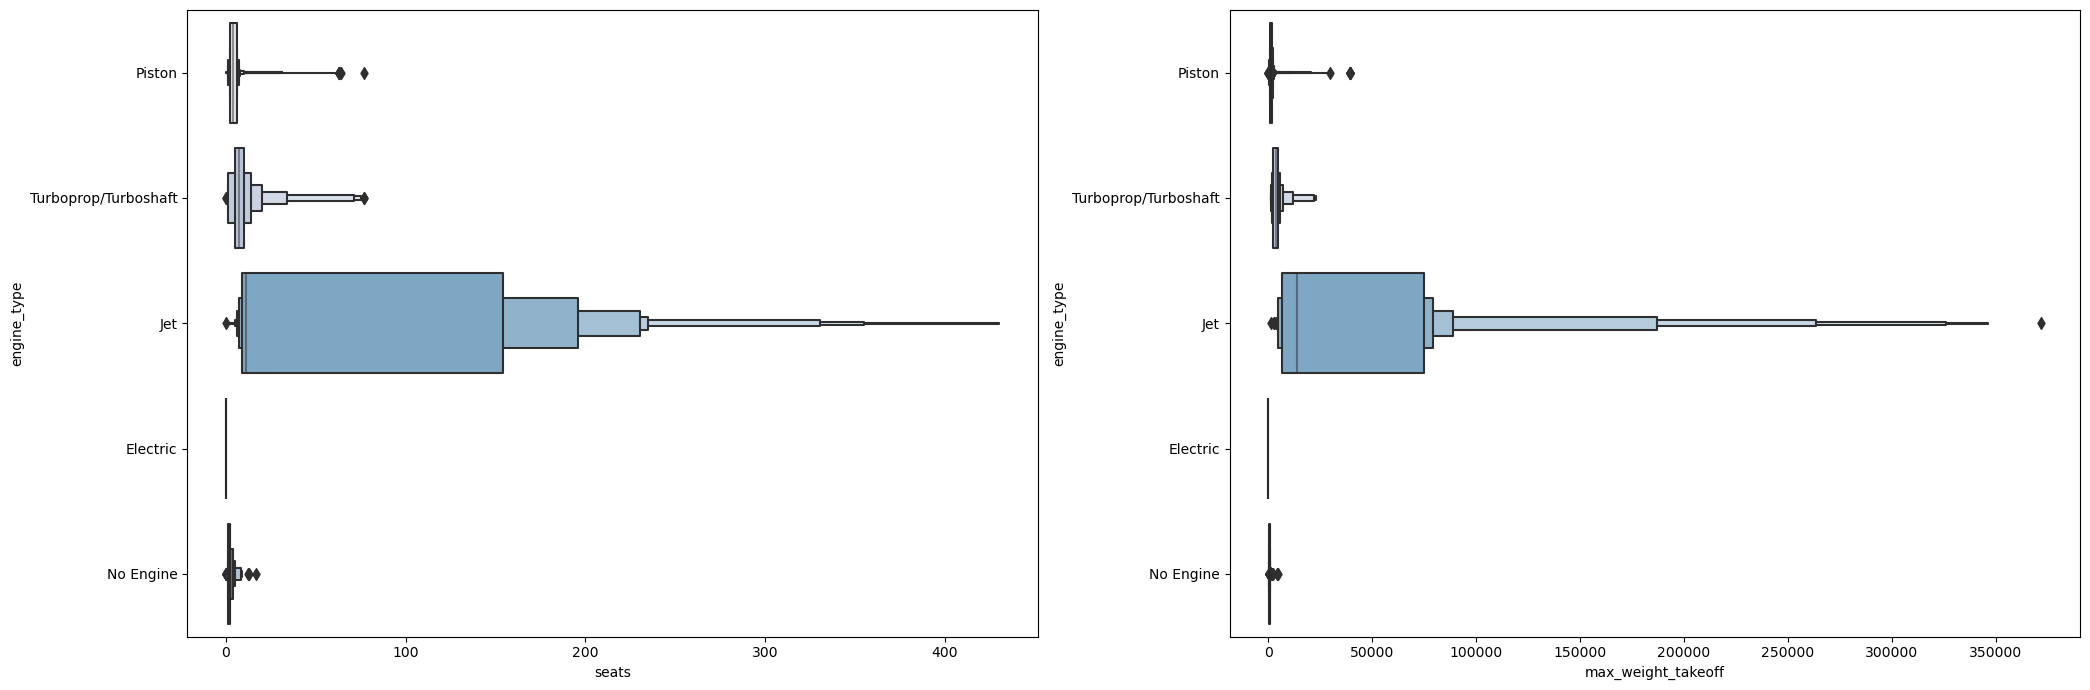

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'engine_type', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'engine_type', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

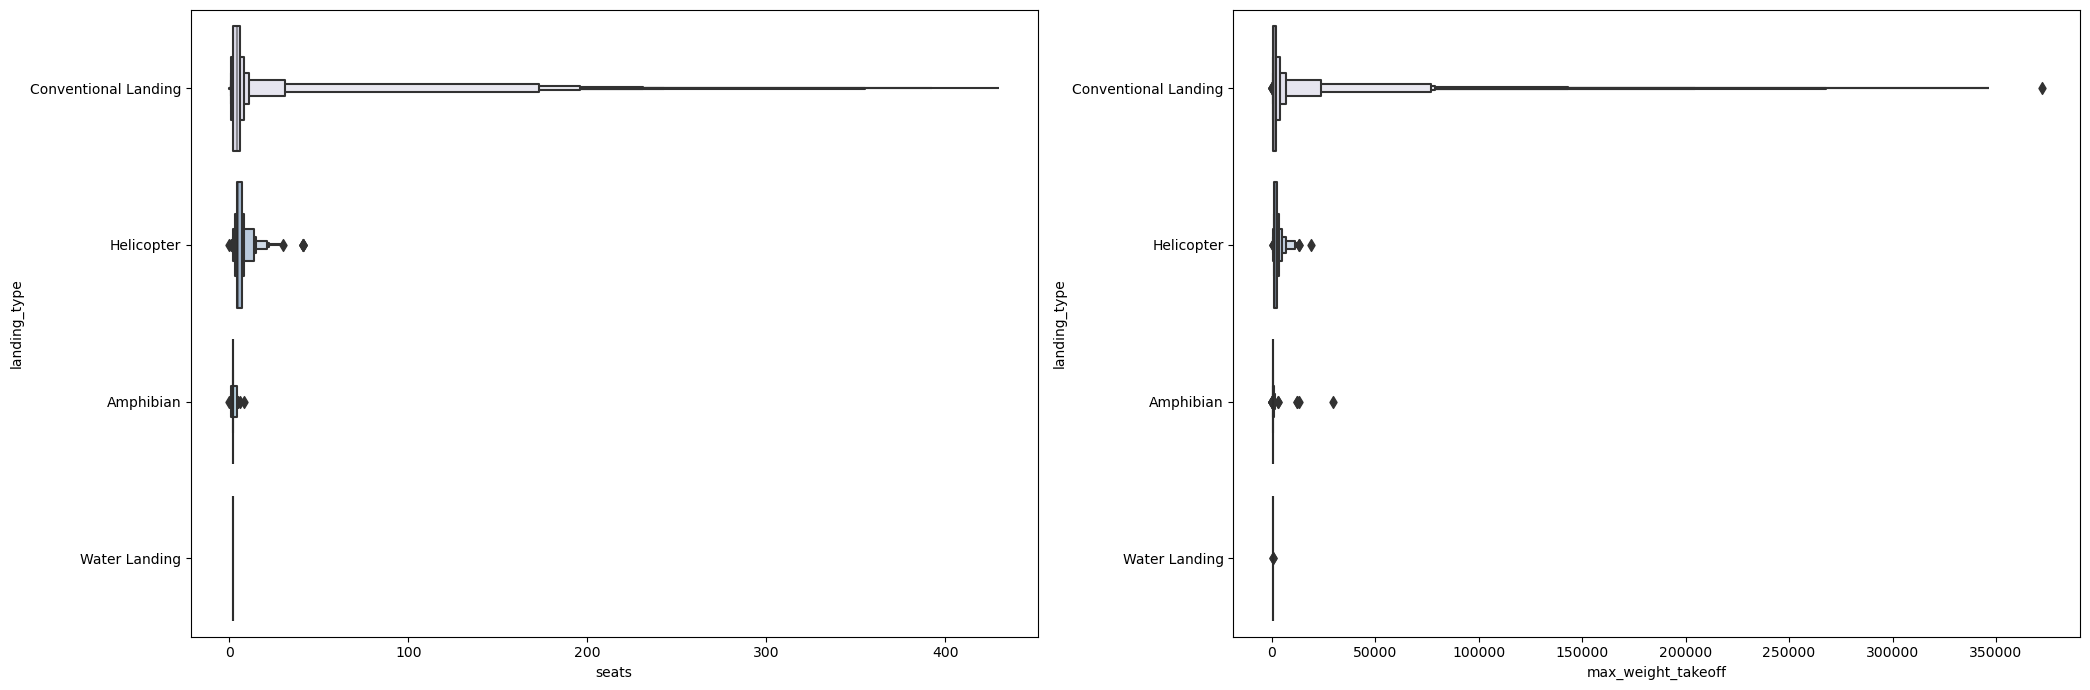

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (21, 7))
sns.boxenplot(data = df, y = 'landing_type', x = 'seats', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[0]);
sns.boxenplot(data = df, y = 'landing_type', x = 'max_weight_takeoff', scale = 'exponential', palette = 'PuBu', orient = 'h', ax = ax[1]);
fig.tight_layout()

## 2.6. Outras Análises

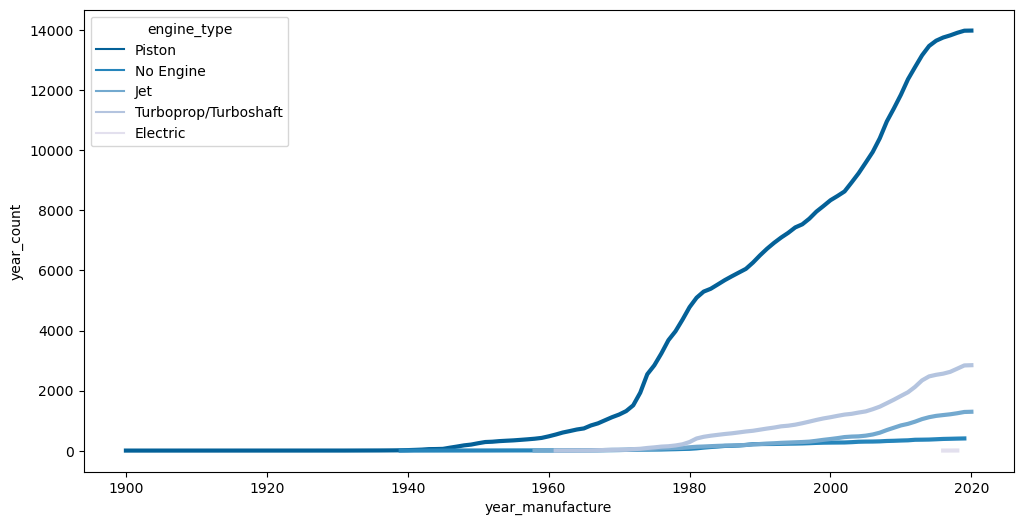

In [41]:
year_count = df.groupby(['year_manufacture', 'engine_type']).count()['owner']
year_count = year_count.groupby(level=1).cumsum()
year_count = year_count.reset_index()
year_count = year_count.rename(columns = {'owner': 'year_count'})

ab = sns.color_palette(palette='PuBu', n_colors=5).as_hex()

plt.figure(figsize = (12, 6))
sns.lineplot(data = year_count, x = 'year_manufacture', y = 'year_count', hue = 'engine_type', palette = ab[::-1], lw = 3);

Aviões a pistão marca uma forte presença no cenário brasileiro ao longo das décadas, notando-se inclinações de crescimento superiores a outros tipos de motores, como Turboprop e Jet.

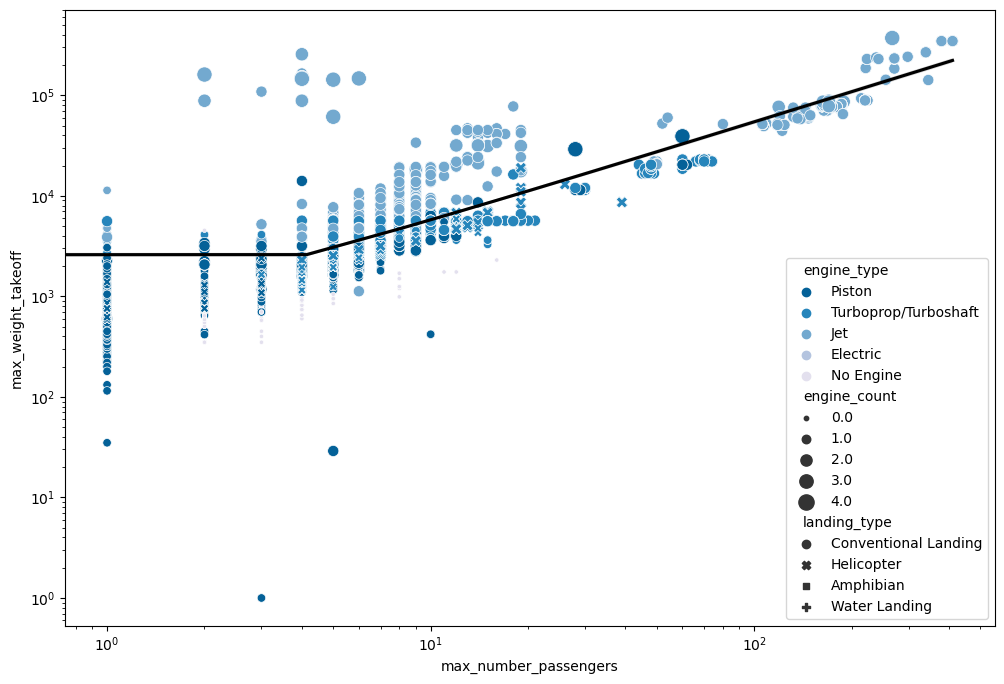

In [42]:
ab = sns.color_palette(palette='PuBu', n_colors=5).as_hex()

plt.figure(figsize = (12, 8))
sns.scatterplot(data = df, x = 'max_number_passengers', y = 'max_weight_takeoff',
                hue = 'engine_type', size = 'engine_count', style =  'landing_type',
                palette = ab[::-1], sizes = (10, 120));
sns.regplot(data=df, x = 'max_number_passengers', y = 'max_weight_takeoff', scatter = False, color = 'k')
plt.yscale('log')
plt.xscale('log')

* Aplicando a transformação logarítmica no MTOW e no número máximo de passageiros, vê-se uma relação linear entre as variáveis.. 
* Aeronaves de três motores ou mais se agrupam em valores superiores de MTOW, apesar do número de passageiros máximo ser relativamente baixo.
* Helicópteros seguem a mesma tendência que as aeronaves com pousagem tradicional.
* Aviões planadores a estão com um peso abaixo da média para seus respectivos números máximo de passageiros.

# 3. Machine Learning

Neste projeto, desenvolveremos um modelo de machine learning capaz de prever o MTOW de uma aeronave com base em variáveis como o número máximo de passageiros, número de motores, tipo de motor e tipo de pouso. O propósito principal desse modelo é oferecer suporte nas fases iniciais do projeto de uma aeronave, quando os objetivos do avião estão sendo definidos.

In [43]:
df['engine_type'] = df['engine_type'].astype('category')
df['landing_type'] = df['landing_type'].astype('category')

X_col = ['max_number_passengers', 'engine_count', 'engine_type', 'landing_type']
y_col = 'max_weight_takeoff'

In [44]:
mask1 = (df['engine_type'] == 'No Engine') | (df['engine_type'] == 'Eletric')
mask2 = (df['landing_type'] == 'Amphibian') | (df['landing_type'] == 'Water Landing')

Dado ao número não significativo de planadores, aviões movidos a motor elétrico, anfíbios e exclusivos de pouso aquático, iremos remover tais valores. 

In [45]:
df_no = df.loc[(mask1 | mask2), :]
df = df.drop(df_no.index)
df = df.drop(df.loc[df[y_col].isna(), y_col].index)

In [46]:
kf = KFold(10, shuffle = True, random_state = 101)

X = df.loc[:, X_col]
y = df.loc[:, y_col]

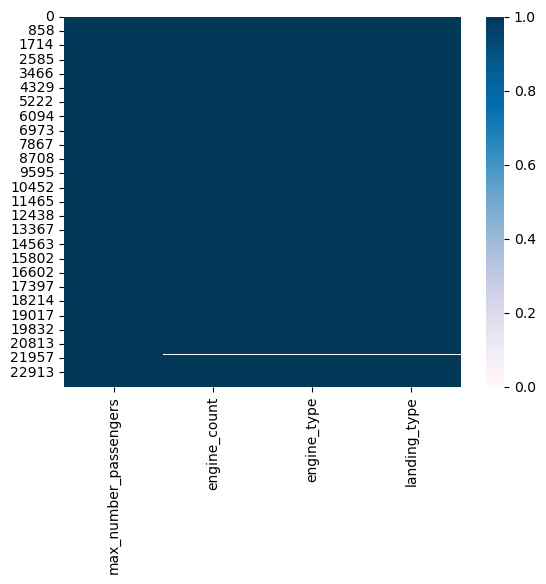

In [47]:
sns.heatmap(X.notna(), cmap = 'PuBu');

Para o presente trabalho, duas aproximações serão consideradas fazendo uso do XGBoost: A primeira com um pré processamento, fazendo uso do target encoder e transformações logarítmicas nas variáveis, bem como um processo de imputação para dados faltantes. Na segunda, não é aplicado qualquer pré-processamento, apenas permitindo que XGBoost trabalhe features categóricas. A métrica escolhida é MAE.

In [48]:
log_features = [0]
categorical_features = [2, 3]

def log1(x): return np.log(x + 1)

def exp1(x): return  np.e ** x - 1

log_transformer = Pipeline(steps = [
    ('log', FunctionTransformer(log1))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', log_transformer, log_features),
    ('cat', categorical_transformer, categorical_features),
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('estimator', xgb.XGBRegressor()),
])

preprocessed_xgb = TransformedTargetRegressor(pipe, 
                           func = log1, 
                           inverse_func = exp1)


In [49]:
cross_val_score(preprocessed_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean()

-611.1243488952167

In [50]:
vanilla_xgb = xgb.XGBRegressor(enable_categorical = True, tree_method = 'hist')

cross_val_score(vanilla_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean()

-498.23461942090506

Dados os resultados, observamos que a segunda aproximação possui um menor erro de validação, sendo a mais adequada para a aplicação.

In [51]:
y_pred_val = cross_val_predict(vanilla_xgb, X, y, cv = kf)
y_pred_train =  vanilla_xgb.fit(X, y).predict(X)

cv_score = cross_val_score(vanilla_xgb, X, y, scoring = 'neg_mean_absolute_error', cv = kf).mean() * (-1)
train_score = mean_absolute_error(y_pred_train, y)

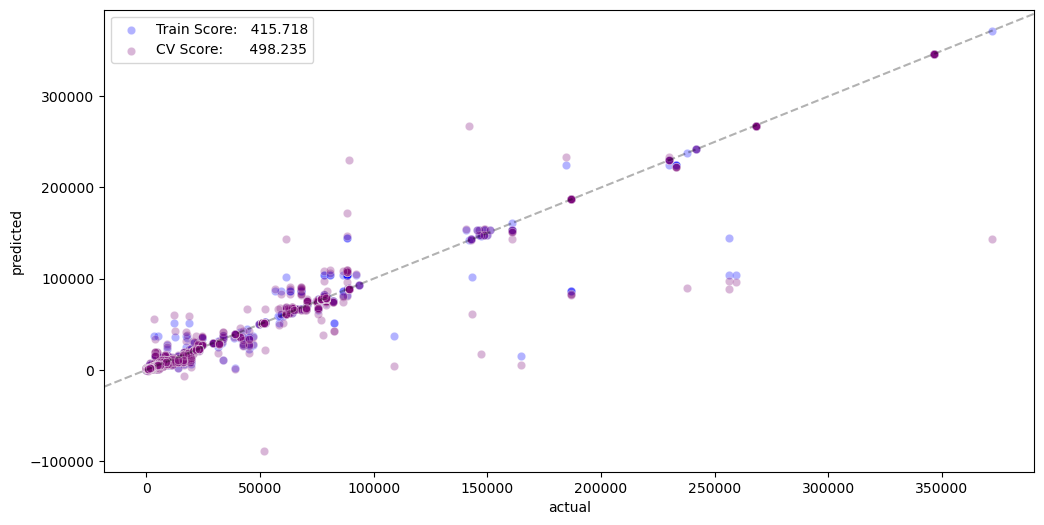

In [52]:
lb1 = 'CV Score: '
lb2 = 'Train Score: '

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
sns.scatterplot(x = y, y = y_pred_train, ax = ax, alpha = 0.3, label = f'{lb2:15s}{train_score:.3f}', color = '#0000ff')
sns.scatterplot(x = y, y = y_pred_val, ax = ax, alpha = 0.3, label = f'{lb1:15s}{cv_score:.3f}', color = '#810f7c')
ax.axline([0, 0], [1, 1], ls = '--', c = 'k', alpha =0.3);
ax.set_xlabel('actual')
ax.set_ylabel('predicted');